# First Year Project
## Project 4 - Natural Language Processing
### Professor - Christian Hardmeier

This notebook contains all of the code developed for project 4. We will be using a data set of tweets to perform machine learning for binary and multiclass classification.

For **binary** classification, we evaluate tweets based on *'ironic'* or *'not ironic'*. [Learn More](https://www.aclweb.org/anthology/S18-1005.pdf)
<br>
For **multiclass** classification, we evaluate predict which emojis are used based on the text data. [Learn More](https://www.aclweb.org/anthology/S18-1003.pdf)

Group 3:<br>
Crisanna Cornish (ccor@itu.dk)<br>
Danielle Dequin (ddeq@itu.dk)<br>
Gino Franco Fazzi (gifa@itu.dk)<br>
Moneeca Abru Iftikhar Latif (abml@itu.dk)<br>
Carl August Wismer (cwis@itu.dk)

Created: 27-04-2021<br>
Last Modified: 04-05-2021

# Data Source

We use the TweetEval repository, a collection of 7 datasets for different classification tasks based on social media post. The repository can be found here: https://github.com/cardiffnlp/tweeteval.git

Each dataset is presented in the same format and with fixed training, validation and test splits.

# Imports

In [1]:
import re
import sys
import csv
import numpy as np
import pandas as pd
from collections import Counter
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.util import ngrams
from nltk.lm import NgramCounter
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.lm import MLE
from nltk.lm import Laplace
from nltk.lm import KneserNeyInterpolated
from nltk.lm import WittenBellInterpolated


import os
import matplotlib.pyplot as plt
from math import log

# Constants

### Paths

In [2]:
# irony text:
IRONY_RAW_PATH = '../datasets/irony/raw/'
IRONY_INTERIM_PATH = '../datasets/irony/interim/'

# emoji:
EMOJI_RAW_PATH = '../datasets/emoji/raw/'
EMOJI_INTERIM_PATH = '../datasets/emoji/interim/'

### FILES:

In [3]:
TEST = 'test_text.txt'
TRAIN = 'train_text.txt'
VAL = 'val_text.txt'

TEST_LABELS = 'test_labels.txt'
TRAIN_LABELS = 'train_labels.txt'
VAL_LABELS = 'val_labels.txt'

TEST_INTERIM = 'test_seperated.csv'
TRAIN_INTERIM = 'train_seperated.csv'
VAL_INTERIM = 'val_seperated.csv'

# FUNCTIONS:

In [4]:
def tokenise(line):
    # Initialise lists
    tokens = []
    unmatchable = []

    # Compile patterns for speedup
    token_pat = re.compile(r'\w+|#+|\'|@|\.\.+|!+|\?+')
    skippable_pat = re.compile(r',|\|http://t.co/+')  # typically spaces

    # As long as there's any material left...
    while line:
        # Try finding a skippable token delimiter first.
        skippable_match = re.search(skippable_pat, line)
        if skippable_match and skippable_match.start() == 0:
            # If there is one at the beginning of the line, just skip it.
            line = line[skippable_match.end():]
        else:
            # Else try finding a real token.
            token_match = re.search(token_pat, line)
            #print(token_match)
            if token_match and token_match.start() == 0:
                #print(line[token_match.start():token_match.end()])
                if line[token_match.start():token_match.end()] == '#': #keep hash tags together and seperate
                    try:
                        token_match2 = re.search(token_pat, line[1:])
                        if ' ' in line[token_match2.start():token_match2.end()]:
                            line = line[token_match.end():]
                        else:
                            tokens.append(line[:token_match2.end()+1])
                            line = line[token_match2.end()+1:]
                    except:
                        line = line[token_match.end():]

                elif line[token_match.start():token_match.end()] == '@': # keep @ tags together and seperate
                    try:
                        token_match2 = re.search(token_pat, line[1:])
                        if ' ' in line[token_match2.start():token_match2.end()]:
                            line = line[token_match.end():]
                        
                        else: 
                            tokens.append(line[:token_match2.end()+1])
                            line = line[token_match2.end()+1:]
                    except:
                        line = line[token_match.end():]

                elif line[token_match.start():token_match.end()] == "'": # handle contractions as a single word
                    try:
                        token_match2 = re.search(token_pat, line[1:])
                        if ' ' in line[token_match2.start():token_match2.end()]:
                            line = line[token_match.end():]
                        
                        else: 
                            tokens.append(line[:token_match2.end()+1])
                            line = line[token_match2.end()+1:]
                    except:
                        line = line[token_match.end():]

                # If there is one at the beginning of the line, tokenise it.
                else:
                    tokens.append(line[:token_match.end()])
                    line = line[token_match.end():]
            else:
                # Else there is unmatchable material here.
                # It ends where a skippable or token match starts, or at the end of the line.
                unmatchable_end = len(line)
                if skippable_match:
                    unmatchable_end = skippable_match.start()
                if token_match:
                    unmatchable_end = min(unmatchable_end, token_match.start())
                # Add it to unmatchable and discard from line.
                unmatchable.append(line[:unmatchable_end])
                line = line[unmatchable_end:]

    final_tokens = []

    while len(tokens) > 0:
        temp1 = tokens.pop(0)
        try:
            temp2 = tokens.pop(0)
            if temp2[0] == "'":
                temp1 += temp2
                final_tokens.insert(0, temp1)
                #print('a', temp1)
            else:
                final_tokens.insert(0, temp1)
                tokens.insert(0, temp2)
                #print('b', temp1, temp2)
        except:
            final_tokens.insert(0, temp1)
            #print('d', temp1)
        
    final_tokens = final_tokens[::-1]

    #print(final_tokens)
    #print(unmatchable)
    return final_tokens

def token_data(data, interim, tokenizer=None):
    """Function to tokenize from raw text file. Takes a reading file path, a writing file path and a
    tokenizer argument (None for default tokenizer, 'Compare' for TweetTokenizer).
    Writes a file with the tokenize lines and returns a list (lines) of lists (tokens)."""
    if tokenizer == None:
        # Open Irony raw data set text and tokenize
        f = open(data, "r", encoding="utf-8")
        token_list = []
        for line in f:
            token_list.append(tokenise(line))
        f.close()
    
    elif tokenizer == "compare":
        tknzr = TweetTokenizer()

        f = open(data, "r", encoding="utf-8")
        token_list = []
        for line in f:
            token_list.append(tknzr.tokenize(line))
        f.close()
        
    # Write the tokenized data to an interim csv file
    with open(interim, "w", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerows(token_list)
        
    return token_list

def token_counter(tokens, n= 10, inverse=False):
    plain = [t for l in tokens for t in l]
    counter = Counter(plain)
    if not inverse:
        return counter.most_common(n)
    else:
        return counter.most_common()[:-n-1:-1]

def zipf_law(tokens, ds_name=''):
    x = [log(x) for x in range(1, len(tokens)+1)]
    y = []

    ordered = token_counter(tokens, n=len(tokens))

    for tup in ordered:
        word, count = tup
        y.append(log(count))
    
    fig, ax = plt.subplots()
    ax.scatter(x, y)
    ax.set_xlabel('Log(Rank)')
    ax.set_ylabel('Log(Freq)')
    ax.set_title(f'Zipf Law for {ds_name} dataset')

# Load data: Task 1

## Load Irony Data Set

In [5]:
# Open Irony data set, tokenize, and write to a csv file
irony = token_data(IRONY_RAW_PATH + TRAIN, IRONY_INTERIM_PATH+TRAIN_INTERIM)

In [6]:
irony[0] # A taste of the tokens

['seeing',
 'ppl',
 'walking',
 'w',
 'crutches',
 'makes',
 'me',
 'really',
 'excited',
 'for',
 'the',
 'next',
 '3',
 'weeks',
 'of',
 'my',
 'life']

## Load Emoji Data Set

In [7]:
# Open Emoji raw dadta set, tokenize, and write to an interim csv file
emoji = token_data(EMOJI_RAW_PATH + TRAIN, EMOJI_INTERIM_PATH+TRAIN_INTERIM)

In [8]:
emoji[0] # A test of emojis

['Sunday',
 'afternoon',
 'walking',
 'through',
 'Venice',
 'in',
 'the',
 'sun',
 'with',
 '@user',
 'Abbot',
 'Kinney',
 'Venice']

## Compare tokeniser’s output 
With the baseline tokenisation from the socialmedia tokeniser in the NLTK library (nltk.tokenize.TweetTokenizer)

In [9]:
# Open emoji data, tokenize with NLTK tokenizer, write to interim csv for comparison
compare_emoji = token_data(EMOJI_RAW_PATH + TRAIN, EMOJI_INTERIM_PATH+'train_seperated_compared.csv',"compare")

In [10]:
print(compare_emoji[3])
print(emoji[3])

['️', '️', '️', '️', '@', 'Toys', '"', 'R', '"', 'Us']
['Toys', 'R', 'Us']


In [11]:
# Open emoji data, tokenize with NLTK tokenizer, write to interim csv for comparison
compare_irony = token_data(IRONY_RAW_PATH + TRAIN, IRONY_INTERIM_PATH+'train_seperated_compared.csv',"compare")

In [12]:
print(compare_irony[3])
print(irony[3])

['@user', '@user', 'So', 'is', 'he', 'banded', 'from', 'wearing', 'the', 'clothes', '?', '#Karma']
['@user', '@user', 'So', 'is', 'he', 'banded', 'from', 'wearing', 'the', 'clothes', '?', '#Karma']


# Characterize Data: Task 2

In [13]:
temp1 = pd.read_csv(IRONY_INTERIM_PATH+TRAIN_INTERIM, delimiter="\n", names=['tweet'])
temp2 = pd.read_csv(IRONY_RAW_PATH+TRAIN_LABELS, names=['label'])
irony_df = temp1.merge(temp2, left_index=True, right_index=True)

## Irony Data

### Number of Tweets

In [14]:
print(f"There are {irony_df.shape[0]} tweets in the Irony data set")
print('Ironic:', (irony_df[irony_df['label'] == 1]).shape[0], '\nNon-ironic:', (irony_df[irony_df['label'] == 0]).shape[0])

There are 2862 tweets in the Irony data set
Ironic: 1445 
Non-ironic: 1417


### Most common Tokens

In [15]:
token_counter(irony)

[('@user', 1731),
 ('the', 964),
 ('to', 934),
 ('a', 757),
 ('I', 724),
 ('is', 483),
 ('and', 470),
 ('!', 464),
 ('in', 440),
 ('of', 426)]

### Least Common Tokens

In [16]:
token_counter(irony, inverse=True)

[('dues', 1),
 ('shorted', 1),
 ('union', 1),
 ('#skincare', 1),
 ('heaven', 1),
 ('products', 1),
 ('thot', 1),
 ('#practicewhatyoupreach', 1),
 ('cracks', 1),
 ('managers', 1)]

In [17]:
irony_tokens = [t for l in irony for t in l] # Get tokens for each line of the irony data set
irony_one_timers = []
irony_mult_timers = []

for tup in token_counter(irony, n=len(irony_tokens)):
    k, v = tup # Unpack
    if v == 1:
        irony_one_timers.append(k)
    else:
        irony_mult_timers.append(k)

In [18]:
print(f'Number of words that occur only once:\
{len(irony_one_timers)} ({len(irony_one_timers)/(len(irony_one_timers)+len(irony_mult_timers)):.0%})\n\
Number of words that occur more than once:\
{len(irony_mult_timers)} ({len(irony_mult_timers)/(len(irony_one_timers)+len(irony_mult_timers)):.0%})\n\
Total word count, including repeated words: {len(irony_tokens)}')

Number of words that occur only once:7250 (70%)
Number of words that occur more than once:3050 (30%)
Total word count, including repeated words: 40371


### Check Zipf's Law

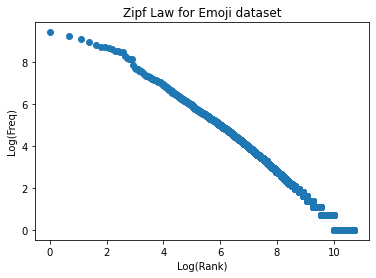

In [19]:
zipf_law(emoji, 'Emoji');

By simple visual inspection, the graph seems to be consistent with the empirical Zipf Law (a semi-straight line crosses the plot).

$$\frac{Type}{Token} ratio$$

In [20]:
len(token_counter(irony, n=len(irony_tokens))) / len(irony_tokens)

0.25513363553045504

## Emoji Data

### Number of Tweets

In [21]:
temp1 = pd.read_csv(EMOJI_INTERIM_PATH+TRAIN_INTERIM, delimiter="\n", names=['tweet'])
temp2 = pd.read_csv(EMOJI_RAW_PATH+TRAIN_LABELS, names=['label'])
emoji_df = temp1.merge(temp2, left_index=True, right_index=True)   

In [22]:
print(f"There are {emoji_df.shape[0]} Tweets in the Emoji data set.") #should be 45000
for i in range(20):
    print(f'{i}: ', (emoji_df[emoji_df['label'] == i].shape[0]))

There are 45000 Tweets in the Emoji data set.
0:  9204
1:  4901
2:  4713
3:  2043
4:  2146
5:  2132
6:  2078
7:  2345
8:  1287
9:  1391
10:  1982
11:  946
12:  1246
13:  980
14:  1224
15:  934
16:  1350
17:  1397
18:  1510
19:  1191


### Most Common Tokens

In [23]:
token_counter(emoji)

[('@user', 12209),
 ('the', 10346),
 ('!', 9045),
 ('to', 7645),
 ('I', 6535),
 ('a', 6100),
 ('my', 5965),
 ('in', 5688),
 ('and', 5389),
 ('with', 5049)]

### Least Common Tokens

In [24]:
token_counter(emoji, inverse=True)

[('Five50', 1),
 ('#happylaborday', 1),
 ('Nunez', 1),
 ('#bffweekend', 1),
 ('Players', 1),
 ('#rolltide', 1),
 ('#Alabama', 1),
 ('chefking1921express', 1),
 ('nector', 1),
 ('thedabberchick', 1)]

In [25]:
emoji_tokens = [t for l in emoji for t in l] # Get tokens for each line of the emoji data set
emoji_one_timers = []
emoji_mult_timers = []

for tup in token_counter(emoji, n=len(emoji_tokens)):
    k, v = tup # Unpack
    if v == 1:
        emoji_one_timers.append(k)
    else:
        emoji_mult_timers.append(k)

In [26]:
print(f'Number of words that occur only once:\
{len(emoji_one_timers)} ({len(emoji_one_timers)/(len(emoji_one_timers)+len(emoji_mult_timers)):.0%})\n\
Number of words that occur more than once:\
{len(emoji_mult_timers)} ({len(emoji_mult_timers)/(len(emoji_one_timers)+len(emoji_mult_timers)):.0%})\n\
Total word count, including repeated words: {len(emoji_tokens)}')

Number of words that occur only once:49420 (69%)
Number of words that occur more than once:21953 (31%)
Total word count, including repeated words: 511305


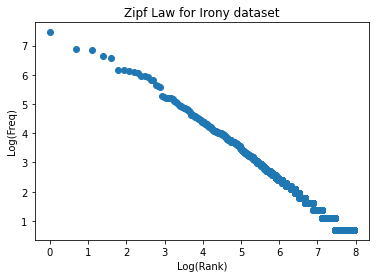

In [27]:
zipf_law(irony, 'Irony');

$$\frac{Type}{Token} ratio$$

In [28]:
len(token_counter(emoji, n=len(emoji_tokens))) / len(emoji_tokens)

0.1395898729721008

# Irony

## Maximum Likelyhood

### Training the model

In [29]:
train, vocab = padded_everygram_pipeline(2, irony)
lm = MLE(2) # Maximum likelyhood estimator or order 2
len(lm.vocab) # Initializes an empty vocab

0

In [30]:
lm.fit(train, vocab) # which is filled with model data
len(lm.vocab)

10303

In [31]:
print(lm.vocab)

<Vocabulary with cutoff=1 unk_label='<UNK>' and 10303 items>


In [32]:
lm.vocab.lookup(irony[0])
print(lm.counts)

<NgramCounter with 2 ngram orders and 89328 ngrams>


In [33]:
lm.score("<UNK>") == lm.score("aliens") # The token 'aliens' is not in our list

True

In [34]:
lm.score("a") # returns the relative frequency of 'a'

0.016422605488664713

In [35]:
lm.logscore("a") # This method avoids underflow

-5.92817315721575

In [36]:
lm.score('A')

0.000954550385074303

In [37]:
lm.score("@user") #most common word

0.03755287992190042

In [38]:
lm.score("a", ["be"]) # Chance that 'a' is preceeded by 'be'

0.14646464646464646

### Testing the Model

In [39]:
#load the validation set
irony_val = token_data(IRONY_RAW_PATH + VAL, IRONY_INTERIM_PATH+VAL_INTERIM)

In [40]:
lm.entropy(irony_val)

inf

In [41]:
lm.perplexity(irony_val)

inf

## Laplace

### Training the model

In [42]:
train, vocab = padded_everygram_pipeline(2, irony)
lm2 = Laplace(1)
len(lm2.vocab) # Initializes an empty vocab
lm2.fit(train, vocab) # which is filled with model data
len(lm2.vocab)

10303

In [43]:
print(lm2.vocab)

<Vocabulary with cutoff=1 unk_label='<UNK>' and 10303 items>


In [44]:
lm2.score("<UNK>") == lm.score("aliens")

False

In [45]:
lm2.score("@user") #most common word

0.030710308876201284

In [46]:
lm2.score("a", ["be"]) # Chance that 'a' is preceeded by 'be'

0.0028568707742119798

### Testing the Model

In [47]:
lm2.entropy(irony_val)

13.333345004312507

In [48]:
lm2.perplexity(irony_val)

10321.356737145781

## KneserNeyInterpolated

### Training the model

In [49]:
train, vocab = padded_everygram_pipeline(2, irony)
lm3 = KneserNeyInterpolated(1)
print(len(lm3.vocab)) # Initializes an empty vocab
lm3.fit(train, vocab) # which is filled with model data
len(lm3.vocab)

0


10303

In [50]:
lm3.score("<UNK>") == lm.score("aliens")

False

In [51]:
lm3.score("@user") #most common word

9.705910899737941e-05

In [52]:
lm3.score("a", ["be"]) # Chance that 'a' is preceeded by 'be'

0.1459661646063665

### Testing the Model

In [53]:
lm3.entropy(irony_val)

13.802139172913105

In [54]:
lm3.perplexity(irony_val)

14284.264894756081

## WittenBellInterpolated

### Training the model

In [55]:
train, vocab = padded_everygram_pipeline(2, irony)
lm4 = WittenBellInterpolated(1)
print(len(lm4.vocab)) # Initializes an empty vocab
lm4.fit(train, vocab) # which is filled with model data
print(len(lm4.vocab))

0
10303


In [56]:
lm4.score("<UNK>") == lm.score("aliens")

True

In [57]:
lm4.score("@user") #most common word

0.03755287992190042

In [58]:
lm4.score("a", ["be"]) # Chance that 'a' is preceeded by 'be'

0.0939777986008466

### Testing the model

In [59]:
lm4.entropy(irony_val)

inf

In [60]:
lm4.perplexity(irony_val)

inf

## Bit of fun

In [61]:
ironic = irony_df[irony_df['label'] == 1]['tweet'].reset_index().drop('index', axis=1)
ironic_list = [t.split(',') for t in ironic['tweet']]

In [62]:
train, vocab = padded_everygram_pipeline(2, ironic_list)
lm_ironic = Laplace(1)
lm_ironic.fit(train, vocab)
lm_ironic.vocab;

In [63]:
#lm_ironic.generate(12, random_seed=4)

# Interrater Task 3

In [64]:
rater_list = ['Dee', 'Sanna', 'Gino', 'August', 'Moneeca']

interrater_df = pd.read_csv('../datasets/iaa-sets/irony/iaa_labels.txt', names = ['True_label'])

for r in rater_list:
    raterX = pd.read_csv('../datasets/iaa-sets/irony/'+r+'Annotation.txt', names = [r])
    interrater_df = interrater_df.merge(raterX, left_index=True, right_index = True)

interrater_df.head()

,True_label,Dee,Sanna,Gino,August,Moneeca
0,1,1,1,1,1,1
1,1,0,0,0,0,0
2,1,0,0,0,0,0
3,0,0,0,1,1,1
4,1,1,0,0,1,1


In [65]:
print("Total Irony labels for true labels: ", str(interrater_df['True_label'].sum()).rjust(9))
for r in rater_list:
    print("Total Irony labels for "+r+" annotator: ", str(interrater_df[r].sum()).rjust(10-len(r)))


Total Irony labels for true labels:         55
Total Irony labels for Dee annotator:       44
Total Irony labels for Sanna annotator:     25
Total Irony labels for Gino annotator:      51
Total Irony labels for August annotator:    31
Total Irony labels for Moneeca annotator:   46


In [66]:
for i in rater_list: # We iterate through all the annotators
    x = interrater_df['True_label'][interrater_df['True_label'] == 1] # Transform labels to TRUE/FALSE
    y = interrater_df[i][interrater_df[i] == 1] # Transform labels to TRUE/FALSE
    ratio = sum(np.bitwise_and(x, y)) / len(x) # Sum all coincidences and divide by the length
    print("Coincidence ratio for "+i+ "{:.1%}".format(ratio).rjust(15-len(i)))


Coincidence ratio for Dee       63.6%
Coincidence ratio for Sanna     38.2%
Coincidence ratio for Gino      60.0%
Coincidence ratio for August    50.9%
Coincidence ratio for Moneeca   60.0%


In [67]:
interrater_df['agree'] =  ((interrater_df['Dee'] + interrater_df['Sanna'] + interrater_df['Gino'] + \
                           interrater_df['August'] + interrater_df['Moneeca']) == 0) |\
(interrater_df['Dee'] + interrater_df['Sanna'] + interrater_df['Gino'] + \
                           interrater_df['August'] + interrater_df['Moneeca'] == 5)

agreed = interrater_df['agree'].sum()
print(f"All annotators agreed in {agreed} number of observations ({agreed/len(interrater_df):.1%})")

All annotators agreed in 48 number of observations (40.0%)


In [68]:
## adjust for chance, assumption that there is a uniform distribution where p = 0.5 to choose 0 or 1.
p = 0.5
a_c = (p)**len(rater_list)

a_adj = (a_0 - a_c)/(1-a_c)

print(f'{a_adj:.1%}')

NameError: name 'a_0' is not defined

Let's explore our interagreement annotations to find our limitations.

In [ ]:
interrater_df[interrater_df['agree'] == False]

### Phenomena that caused the biggest problems for inter-annotator agreement

* Lack of context to give understanding of the text. For example, some seem to reference a photo
* Some texts refer to specific pop culture or niche subject matter that was not understood or known by the annotators. For example, reference to sports, people, or twitter related subject matter.
* Perspective biases of the annotators based on gender, culture, personal background, previous experience or work.
* Emojis in the text do not clarify the understanding of the text itself.
* Poor grammer/ sentense structure/ spelling, etc making it difficult to understand the text. **Schizophrenic twits**.

In addition, we noticed inconsistencies with our own annotation choices (intra-annotations).
